In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from umap.umap_ import UMAP
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm
from collections import Counter
import itertools
import nltk
import pymorphy2
import torch
from transformers import AutoTokenizer, AutoModel
import time


START_TIME = time.time()
TOKENIZER = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
BERT = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
BERT.cuda()
nltk.download('punkt')
MORPH = pymorphy2.MorphAnalyzer()

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   P

In [33]:
df_train = pd.read_csv("content/train.csv", index_col=0)
df_train = df_train[df_train.full_reads_percent < 100]
df_test = pd.read_csv("content/test.csv", index_col=0)
df_test['url'] = df_test.index.str[:24]
df_train['url'] = df_train.index.str[:24]

In [34]:
scraped = pd.read_csv("content/scraped.csv", index_col=0)
scraped.text.fillna('', inplace=True)

In [35]:
for targ in ['views', 'depth', 'full_reads_percent']:
    df_test[targ] = -1
united = pd.concat([df_train, df_test])

In [36]:
united_sc = pd.merge(united, scraped, on=['url'], how="left")

In [37]:
for col in ['article_word_count', 'keywords', 'text', 'description']:
    united[col] = united_sc[col].values
sc_authors = []
for auth in united_sc.article_authors.values:
    sc_authors.append(f'[{auth}]')
united['scraped_authors'] = sc_authors
united['title_y'] = united_sc['title_y'].str[:-6].values
united['article_word_count'] = united['article_word_count'].values.astype(int)

In [38]:
united['title_len'] = united.title.str.len()
united['clear_title'] = [x.split('\n')[0] for x in united.title.values]
united['text_len'] = united.text.str.len()
united['descr_len'] = united.description.str.len()
united['parts_c'] = united.text.str.count('\|')
united['url_c'] = united.url.map(united.url.value_counts())

pub_date = pd.to_datetime(united.publish_date).dt
united['pub_date_h'] = pub_date.hour
united['pub_date_mo'] = pub_date.month
united['pub_date_md'] = pub_date.day
united['pub_date_wd'] = pub_date.dayofweek
united['pub_date_yd'] = pub_date.dayofyear


In [39]:
united['cat_enc'] = united.category.map(united.category.value_counts().to_dict())
united['n_pub_date_yd'] = united.pub_date_yd.map(united.pub_date_yd.value_counts().to_dict())
united['n_pub_date_md'] = united.pub_date_md.map(united.pub_date_md.value_counts().to_dict())
united['n_pub_date_h'] = united.pub_date_h.map(united.pub_date_h.value_counts().to_dict())
united['ctr_c'] = united.ctr.map(united.ctr.value_counts().to_dict())

In [40]:
def get_stats(df, field):
    pops = Counter(list(itertools.chain.from_iterable([eval(x) for x in df[field].values])))
    for key, value in pops.items():
        pops[key] = value + np.random.random() * 0.01
    stats = {'means': [],
             'mins': [],
             'maxs': [],
             'medians': [],
             'stds': [],
             'covs': []}
    for values in df[field].values:
        vals = eval(values)
        res = np.zeros(len(vals))
        for idx, val in enumerate(vals):
            res[idx] = pops[val]
        if len(vals) == 0:
            res = np.array([-1])
        stats['means'].append(res.mean())
        stats['mins'].append(res.min())
        stats['maxs'].append(res.max())
        stats['medians'].append(np.median(res))
        stats['stds'].append(res.std())
        stats['covs'].append(stats['stds'][-1] / stats['means'][-1])
    for name in ['means', 'mins', 'maxs', 'medians', 'stds', 'covs']:
        united[f'{field}_{name}'] = stats[name]

In [41]:
np.random.seed(42)
get_stats(united, 'tags')
get_stats(united, 'authors')
get_stats(united, 'scraped_authors')


In [42]:
def preprocess(text: str) -> list:
    tokenized = nltk.word_tokenize(text.lower())
    normalized = [MORPH.parse(word)[0].normal_form for word in tokenized
                  if len(word) > 1 and word.isalpha()]
    return normalized


def tf_idf(freqs):
    return (freqs / (freqs.sum(axis=1) + 0.0001)[:, np.newaxis] ) * np.log(freqs.shape[0] / ((freqs >= 1).sum(axis=0) + 1))

def mess_to_vec(vocab: dict, message: list):
    vec = np.zeros(len(vocab) + 1)
    for token in message:
        if token in vocab:
            vec[vocab[token]] += 1
        else:
            vec[0] += 1
    return vec

def get_vocab(messages: list) -> dict:
    vocab = {}
    pos = 1
    cc = Counter()
    for message in messages:
        n_cc = Counter(message)
        for key in n_cc:
            n_cc[key] = 1
        cc += n_cc
    for key, val in cc.items():
        if val > 1:
            vocab[key] = pos
            pos += 1
    return vocab

def get_tf_idf_enc(vals, new_df, name):
    vocab = get_vocab(vals)

    all_freq = []
    for val in vals:
        all_freq.append(mess_to_vec(vocab, val))
    all_freq = np.array(all_freq)

    all_freq = tf_idf(all_freq)
    reduct = UMAP(densmap=True,
                  dens_lambda=1.,
                  n_neighbors=10,
                  min_dist=0.0,
                  n_components=3,
                  random_state=42,
                  low_memory=False,
                  metric='cosine',
                  output_metric='euclidean'
                  )

    umap_res = reduct.fit_transform(all_freq).T
    for i in range(len(umap_res)):
        new_df[name + f'_umap_{i}'] = umap_res[i]

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

def get_bert_enc(df):
    embeds = []
    for vals in df[['title_y', 'description', 'text']].itertuples():
        embeds.append(embed_bert_cls('\n'.join((vals[1], vals[2], vals[3].replace('|', '\n'))), BERT, TOKENIZER))
    embeds = np.array(embeds)

    reduct = UMAP(densmap=True,
                  dens_lambda=1.,
                  n_neighbors=10,
                  min_dist=0.0,
                  n_components=3,
                  random_state=42,
                  low_memory=False,
                  metric='euclidean',
                  output_metric='euclidean'
                  )

    umap_res = reduct.fit_transform(embeds).T
    for i in range(len(umap_res)):
        df[f'bert_umap_{i}'] = umap_res[i]

In [43]:
for name in ['title_y', 'description', 'text']:
    vals = [word.lower() for word in united[name].values]
    get_tf_idf_enc(vals, united, f'{name}_symb')

vals = [preprocess(word) for word in united.keywords.values]
get_tf_idf_enc(vals, united, 'key_words')

get_bert_enc(united)

In [44]:
class RFStack:
    def __init__(self, df):

        self.auth_pops = None
        self.train_df = self.get_preprocessed(df)
        self.target = df[['views', 'depth', 'full_reads_percent']]
        self.reg_model = RandomForestRegressor(random_state=42, n_jobs=-1, min_samples_leaf=5, oob_score=True)
        self.reg_model.fit(self.train_df, self.target)
        self.print_score()

    def get_preprocessed(self, df):
        train_df = df[['ctr']].copy()

        pub_date = pd.to_datetime(df.publish_date).dt
        train_df['pub_date_h'] = pub_date.hour
        train_df['pub_date_mo'] = pub_date.month
        train_df['pub_date_md'] = pub_date.day
        train_df['pub_date_wd'] = pub_date.dayofweek
        train_df['pub_date_yd'] = pub_date.dayofyear

        if self.auth_pops is None:
            np.random.seed(42)
            self.auth_pops = Counter(list(itertools.chain.from_iterable([eval(x) for x in df['authors'].values])))
            for key, value in self.auth_pops.items():
                self.auth_pops[key] = value + np.random.random() * 0.01

        auth_enc = []
        for values in df['authors'].values:
            vals = eval(values)
            res = []
            for val in vals:
                if val in self.auth_pops:
                    res.append(self.auth_pops[val])
            if len(vals) == 0:
                res = np.array([-1])
            auth_enc.append(np.array(res).mean())
        train_df['authors_enc'] = auth_enc

        embeds = []
        for vals in df['title'].values:
            embeds.append(embed_bert_cls(vals, BERT, TOKENIZER))
        embeds = np.array(embeds).T
        for i in range(len(embeds)):
            train_df[f'bert_{i}'] = embeds[i]

        return train_df.copy()

    def print_score(self):
        oob_views = r2_score(self.target['views'], self.reg_model.oob_prediction_[:, 0])
        oob_depth = r2_score(self.target['depth'], self.reg_model.oob_prediction_[:, 1])
        oob_frp = r2_score(self.target['full_reads_percent'], self.reg_model.oob_prediction_[:, 2])
        print(f'oob {0.4 * oob_views + 0.3 * oob_depth + 0.3 * oob_frp} ({oob_views}, {oob_depth}, {oob_frp})')

    def predict(self, df):
        data = self.get_preprocessed(df)
        return self.reg_model.predict(data)

In [45]:
additional = pd.read_csv("content/output_10k.tsv", index_col=0, sep='\t')
rf_stack = RFStack(additional)
rf_pred = rf_stack.predict(united).T
for i, val in enumerate(['views', 'depth', 'full_reads_percent']):
    united[f'stack_{val}'] = rf_pred[i]

C:\Users\user\AppData\Local\Temp\ipykernel_8980\1706915848.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f'bert_{i}'] = embeds[i]
C:\Users\user\AppData\Local\Temp\ipykernel_8980\1706915848.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f'bert_{i}'] = embeds[i]
C:\Users\user\AppData\Local\Temp\ipykernel_8980\1706915848.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

oob 0.307167860022858 (0.43289636730821035, 0.27350367608128023, 0.17319403425063273)


C:\Users\user\AppData\Local\Temp\ipykernel_8980\1706915848.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f'bert_{i}'] = embeds[i]
C:\Users\user\AppData\Local\Temp\ipykernel_8980\1706915848.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f'bert_{i}'] = embeds[i]
C:\Users\user\AppData\Local\Temp\ipykernel_8980\1706915848.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

In [46]:
features = ['url_c', 'text_len','descr_len', 'parts_c', 'article_word_count', 'title_len',  'pub_date_h', 'pub_date_mo', 'pub_date_wd',
            'pub_date_md', 'pub_date_yd', 'cat_enc', 'ctr', 'n_pub_date_yd', 'n_pub_date_md', 'n_pub_date_h', 'ctr_c']
stats = ['means', 'mins', 'maxs', 'medians', 'stds', 'covs']
features += [f'tags_{name}' for name in stats]
features += [f'authors_{name}' for name in stats]
features += [f'scraped_authors_{name}' for name in stats]
features += list(united.columns[-18:])

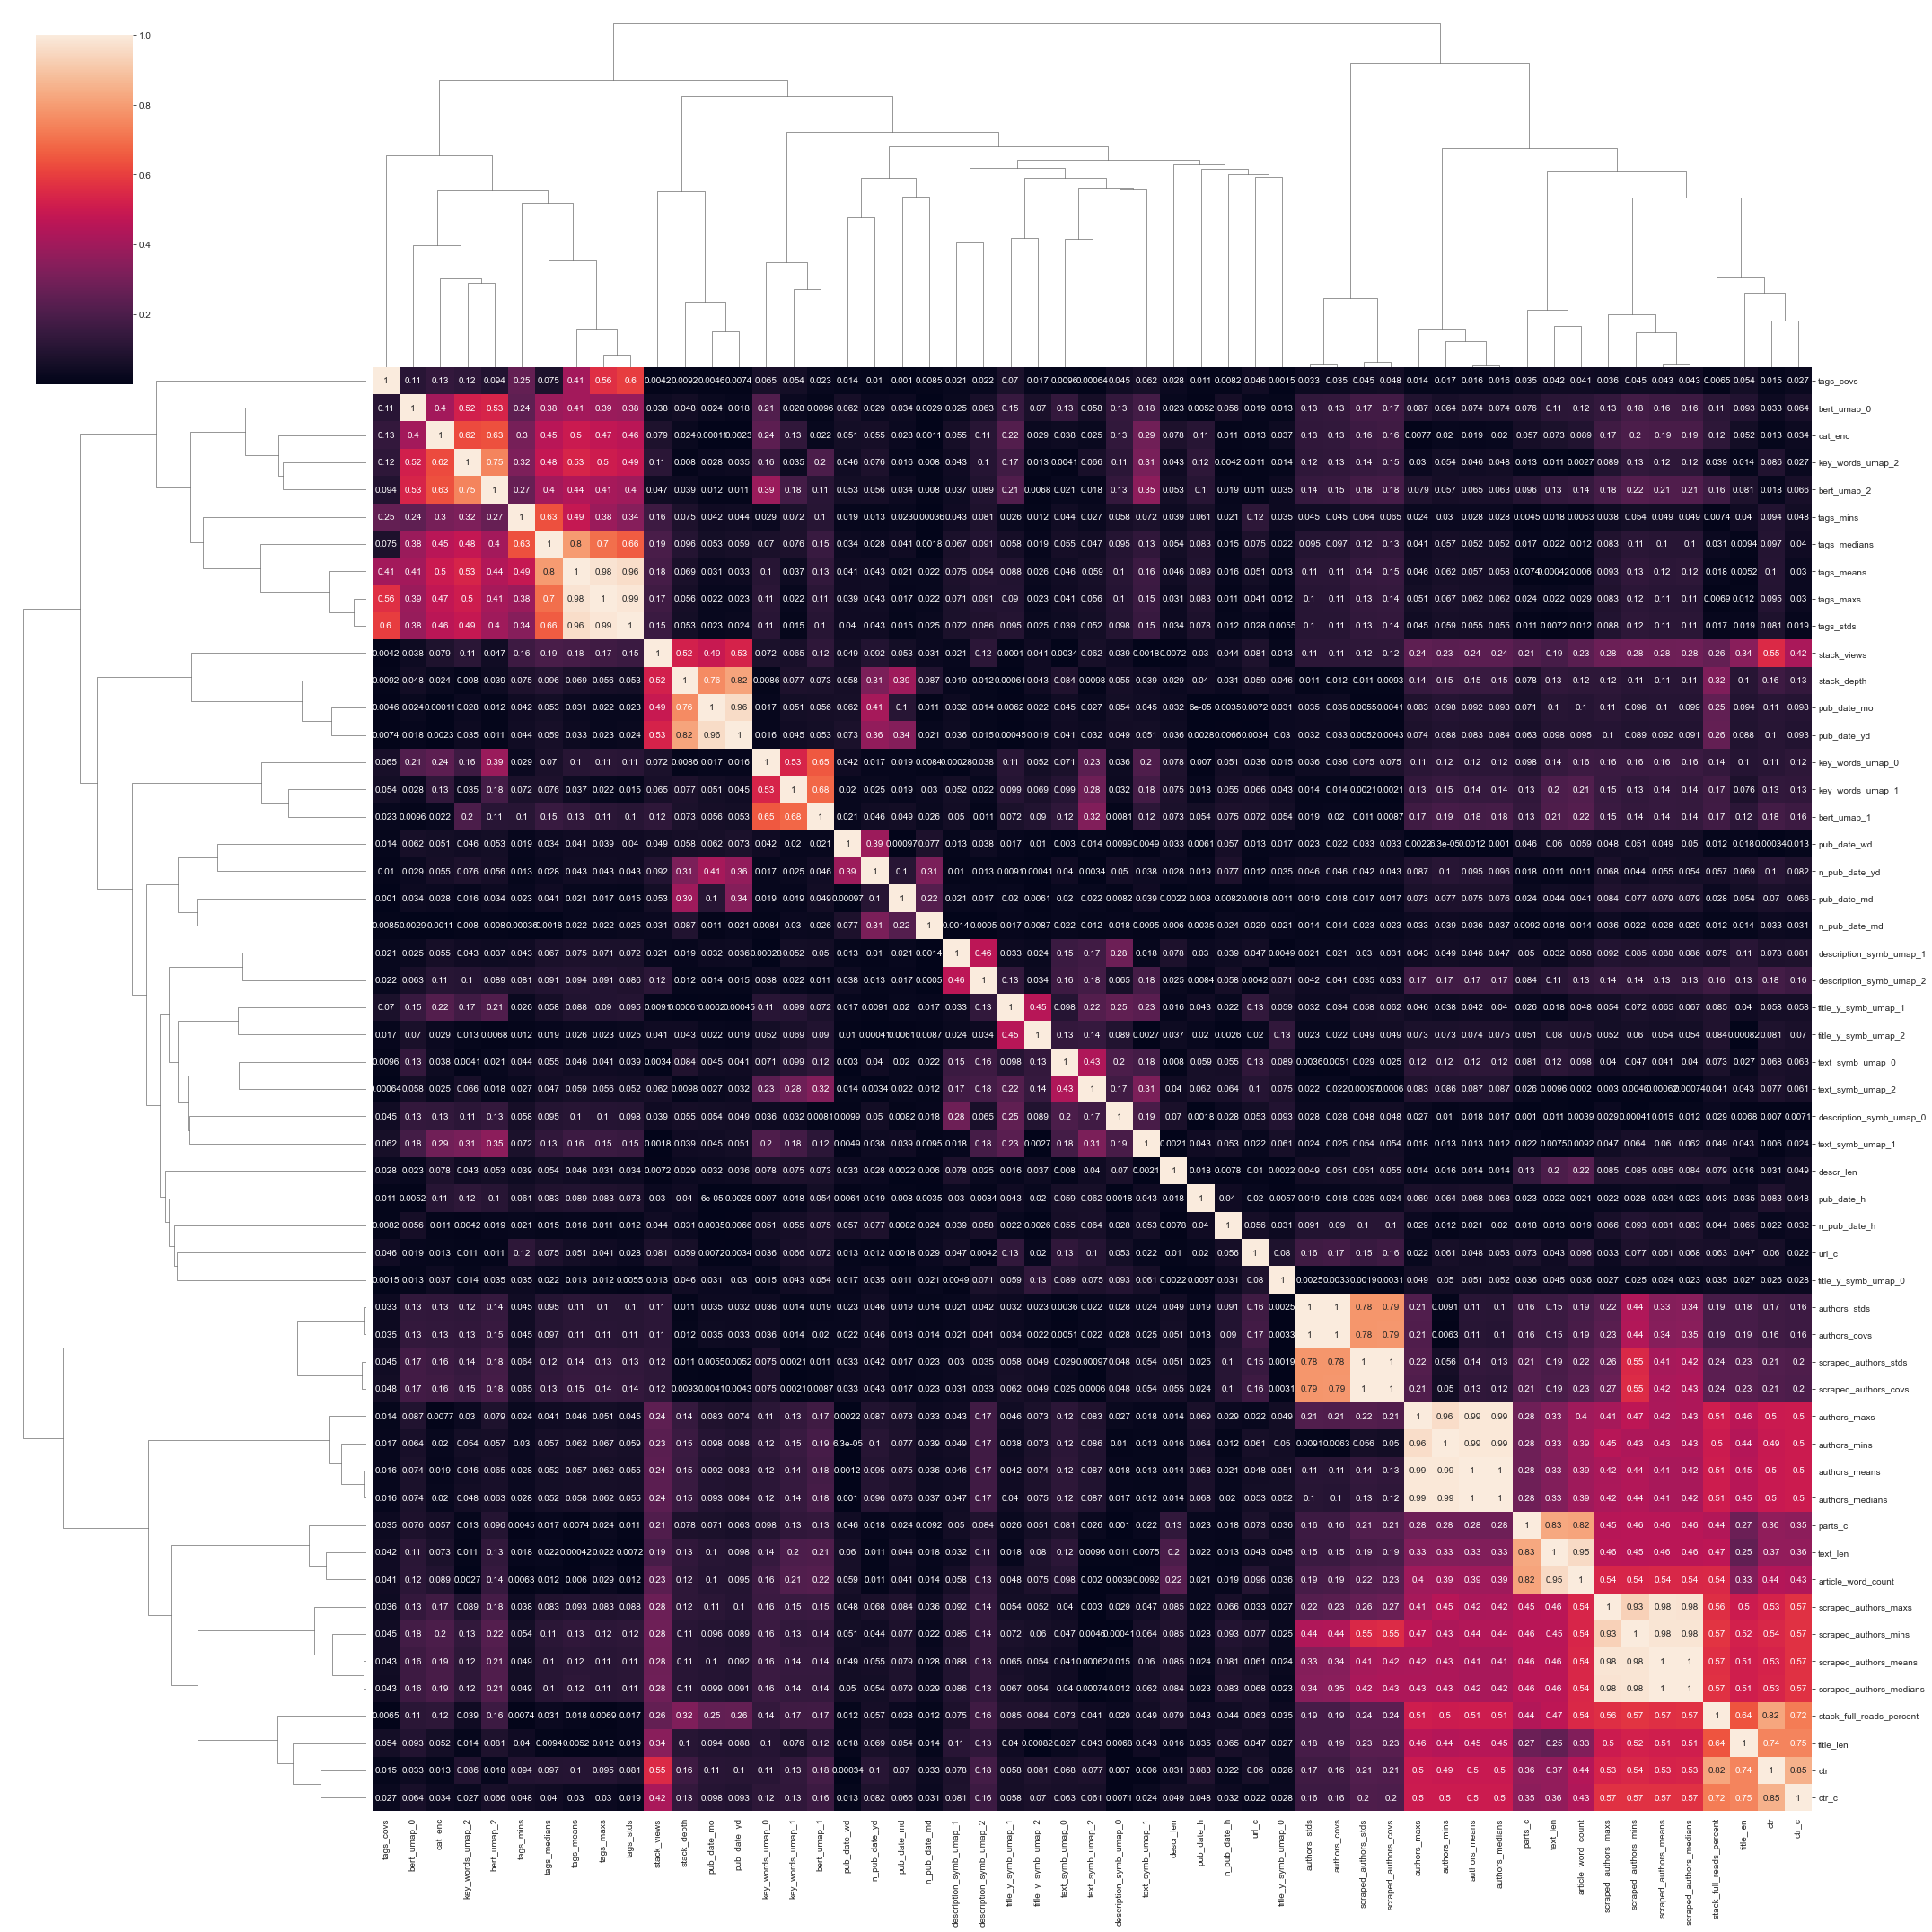

In [47]:
sns.clustermap(np.abs(united[features].corr('spearman')), figsize=(30, 30), annot=True)
plt.show()

In [48]:
test = united[united.views == -1]
train = united[united.views != -1]

train, val = train_test_split(train, random_state=42, test_size=0.25)

In [49]:
def lgbm_r2(y_true, y_pred):
    return 'r2', r2_score(y_true, y_pred), True

In [50]:
lgbm_views = lightgbm.LGBMRegressor(num_leaves=7, n_estimators=3500, learning_rate=0.01)
lgbm_views = lgbm_views.fit(train[features], train['views'],
                            eval_set=[(train[features], train['views']), (val[features], val['views'])],
                            eval_names=['train', 'val'], eval_metric=lgbm_r2, callbacks=[lightgbm.log_evaluation(500)])

[500]	train's l2: 2.02693e+09	train's r2: 0.79841	val's l2: 1.20468e+09	val's r2: 0.80884
[1000]	train's l2: 1.06915e+09	train's r2: 0.893667	val's l2: 6.99411e+08	val's r2: 0.889017
[1500]	train's l2: 6.74022e+08	train's r2: 0.932965	val's l2: 5.54173e+08	val's r2: 0.912064
[2000]	train's l2: 4.79113e+08	train's r2: 0.952349	val's l2: 5.14013e+08	val's r2: 0.918436
[2500]	train's l2: 3.53148e+08	train's r2: 0.964877	val's l2: 4.88094e+08	val's r2: 0.922549
[3000]	train's l2: 2.81813e+08	train's r2: 0.971972	val's l2: 4.80662e+08	val's r2: 0.923728
[3500]	train's l2: 2.30957e+08	train's r2: 0.97703	val's l2: 4.82054e+08	val's r2: 0.923508


In [51]:
r2_score(val['views'], lgbm_views.predict(val[features]))

0.9235075383424173

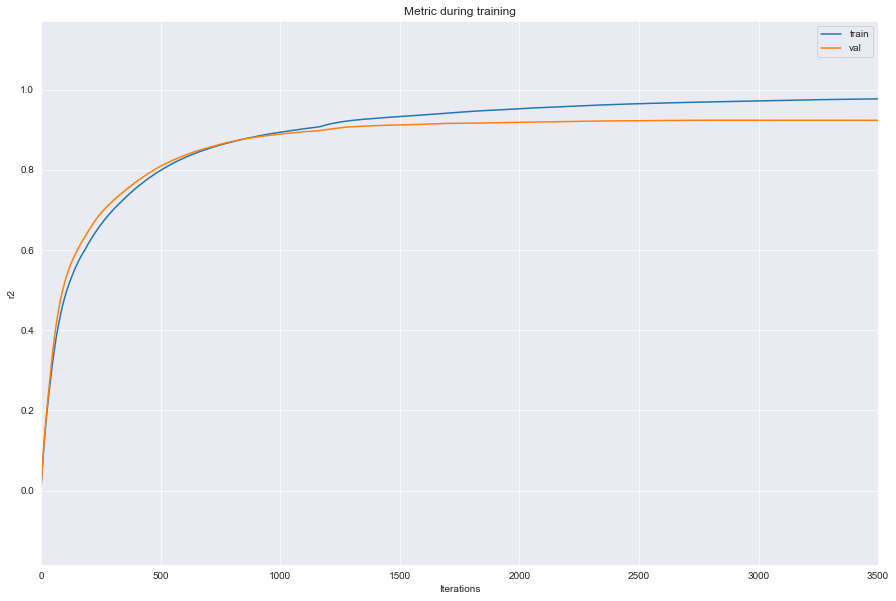

In [52]:
lightgbm.plot_metric(lgbm_views, metric='r2', figsize=(15, 10));

In [53]:
lgbm_depth = lightgbm.LGBMRegressor(num_leaves=11, n_estimators=3500, learning_rate=0.01)
lgbm_depth = lgbm_depth.fit(train[features], train['depth'],
                            eval_set=[(train[features], train['depth']), (val[features], val['depth'])],
                            eval_names=['train', 'val'], eval_metric=lgbm_r2, callbacks=[lightgbm.log_evaluation(500)])

[500]	train's l2: 0.000508453	train's r2: 0.880632	val's l2: 0.000676547	val's r2: 0.836169
[1000]	train's l2: 0.00039978	train's r2: 0.906145	val's l2: 0.000626519	val's r2: 0.848283
[1500]	train's l2: 0.000336199	train's r2: 0.921072	val's l2: 0.000612249	val's r2: 0.851739
[2000]	train's l2: 0.000286927	train's r2: 0.932639	val's l2: 0.000607681	val's r2: 0.852845
[2500]	train's l2: 0.000246804	train's r2: 0.942059	val's l2: 0.000603366	val's r2: 0.85389
[3000]	train's l2: 0.000215235	train's r2: 0.94947	val's l2: 0.000600221	val's r2: 0.854651
[3500]	train's l2: 0.000188273	train's r2: 0.9558	val's l2: 0.000600676	val's r2: 0.854541


In [54]:
r2_score(val['depth'], lgbm_depth.predict(val[features]))

0.8545414099077165

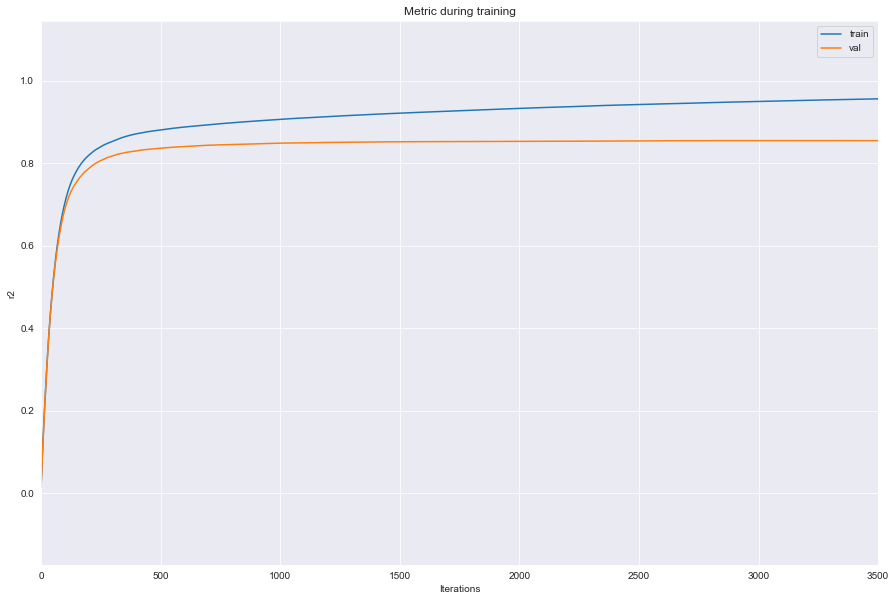

In [55]:
lightgbm.plot_metric(lgbm_depth, metric='r2', figsize=(15, 10));

In [56]:
lgbm_full_reads_percent = lightgbm.LGBMRegressor(num_leaves=11, n_estimators=3500, learning_rate=0.01)
lgbm_full_reads_percent = lgbm_full_reads_percent.fit(train[features], train['full_reads_percent'],
                                                      eval_set=[(train[features], train['full_reads_percent']),
                                                                (val[features], val['full_reads_percent'])],
                                                      eval_names=['train', 'val'], eval_metric=lgbm_r2,
                                                      callbacks=[lightgbm.log_evaluation(500)])

[500]	train's l2: 27.3682	train's r2: 0.739398	val's l2: 30.4154	val's r2: 0.693722
[1000]	train's l2: 22.1353	train's r2: 0.789226	val's l2: 28.5409	val's r2: 0.712598
[1500]	train's l2: 18.9822	train's r2: 0.81925	val's l2: 27.9747	val's r2: 0.7183
[2000]	train's l2: 16.4753	train's r2: 0.843121	val's l2: 27.5668	val's r2: 0.722406
[2500]	train's l2: 14.5752	train's r2: 0.861213	val's l2: 27.3837	val's r2: 0.724251
[3000]	train's l2: 12.9144	train's r2: 0.877028	val's l2: 27.1845	val's r2: 0.726256
[3500]	train's l2: 11.4888	train's r2: 0.890603	val's l2: 27.1034	val's r2: 0.727073


In [57]:
r2_score(val['full_reads_percent'].values, lgbm_full_reads_percent.predict(val[features]))

0.7270733363622851

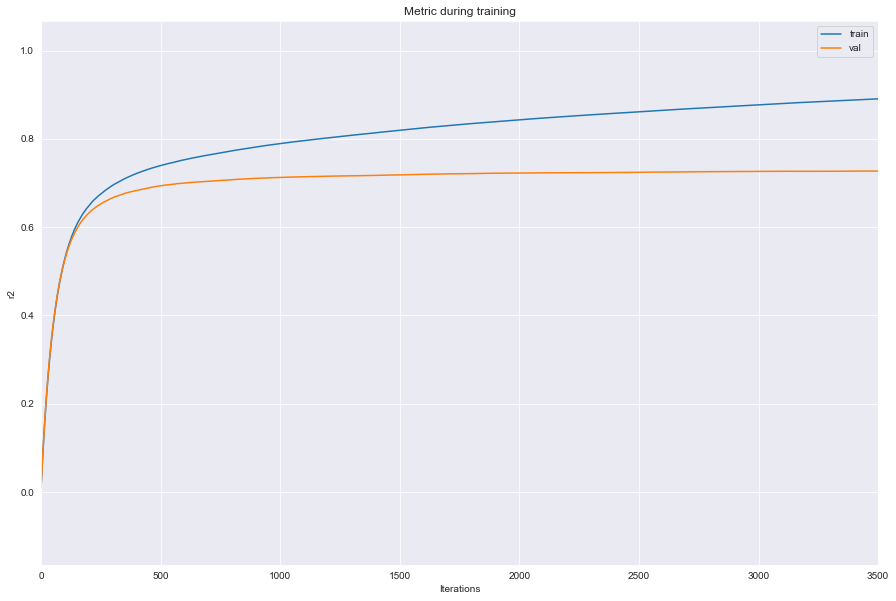

In [58]:
lightgbm.plot_metric(lgbm_full_reads_percent, metric='r2', figsize=(15, 10));

In [59]:
0.4 * r2_score(val['views'], lgbm_views.predict(val[features])) + 0.3 * r2_score(val['depth'], lgbm_depth.predict(val[features])) + 0.3 * r2_score(val['full_reads_percent'].values, lgbm_full_reads_percent.predict(val[features]))

0.8438874392179674

In [60]:
test['views'] = lgbm_views.predict(test[features])
test['depth'] = lgbm_depth.predict(test[features])
test['full_reads_percent'] = lgbm_full_reads_percent.predict(test[features])

C:\Users\user\AppData\Local\Temp\ipykernel_8980\4266324362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['views'] = lgbm_views.predict(test[features])
C:\Users\user\AppData\Local\Temp\ipykernel_8980\4266324362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['depth'] = lgbm_depth.predict(test[features])
C:\Users\user\AppData\Local\Temp\ipykernel_8980\4266324362.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [61]:
test[['views', 'depth', 'full_reads_percent']].to_csv('f_sol_3.csv', line_terminator='\n')

In [62]:
print(f'Execution time {time.time() - START_TIME:0.2f}s')

Execution time 464.53s
